<a href="https://colab.research.google.com/github/crux82/ganbert-pytorch/blob/main/GANBERT_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN-BERT (in Pytorch and compatible with HuggingFace)

This is a Pytorch (+ **Huggingface** transformers) implementation of the GAN-BERT model from https://github.com/crux82/ganbert. While the original GAN-BERT was an extension of BERT, this implementation can be adapted to several architectures, ranging from Roberta to Albert!

**NOTE**: given that this implementation is different from the original one in Tensorflow, some results can be slighty different.


Let's GO!

Required Imports.

## Importing Library

In [1]:
!pip install transformers==4.3.2
import torch
import io
import torch.nn.functional as F
import random
import numpy as np
import time
import math
import datetime
import torch.nn as nn
from transformers import *
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
#!pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 -f https://download.pytorch.org/whl/torch_stable.html
#!pip install sentencepiece

##Set random values
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(seed_val)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 6.8 MB/s 
     |████████████████████████████████| 880 kB 31.8 MB/s 
     |████████████████████████████████| 3.3 MB 40.4 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=ccfcc0f991a39b10a89c17b9d45550e670a13d789254fca9fb6704f52b14a6ee
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses


## Mounting Drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
%cd "/content/gdrive/My Drive/GAN-BERT/data_CLINC150"

/content/gdrive/My Drive/GAN-BERT/data_CLINC150


In [4]:
import os
os.listdir('./')

['Data_Preparation.ipynb',
 'data_full.json',
 '10_90',
 '.ipynb_checkpoints',
 '20_80',
 '40_60',
 'ganbert',
 '1_99',
 '2_98',
 '5_95',
 '50_50',
 '30_70',
 'test.tsv',
 'test_OOS.tsv']

In [5]:
# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


### Input Parameters


In [6]:
#--------------------------------
#  Transformer parameters
#--------------------------------
max_seq_length = 64
batch_size = 64

#--------------------------------
#  GAN-BERT specific parameters
#--------------------------------
# number of hidden layers in the generator, 
# each of the size of the output space
num_hidden_layers_g = 1; 
# number of hidden layers in the discriminator, 
# each of the size of the input space
num_hidden_layers_d = 1; 
# size of the generator's input noisy vectors
noise_size = 100
# dropout to be applied to discriminator's input vectors
out_dropout_rate = 0.2

# Replicate labeled data to balance poorly represented datasets, 
# e.g., less than 1% of labeled material
apply_balance = True

#--------------------------------
#  Optimization parameters
#--------------------------------
learning_rate_discriminator = 5e-5
learning_rate_generator = 5e-5
epsilon = 1e-8
num_train_epochs = 5
multi_gpu = True
# Scheduler
apply_scheduler = False
warmup_proportion = 0.1
# Print
print_each_n_step = 10

#--------------------------------
#  Adopted Tranformer model
#--------------------------------
# Since this version is compatible with Huggingface transformers, you can uncomment
# (or add) transformer models compatible with GAN

model_name = "bert-base-cased"
#model_name = "bert-base-uncased"
#model_name = "roberta-base"
#model_name = "albert-base-v2"
#model_name = "xlm-roberta-base"
#model_name = "amazon/bort"
#model_name = "prajjwal1/bert-tiny"


#--------------------------------
#  Retrieve the TREC QC Dataset
#--------------------------------
! git clone https://github.com/crux82/ganbert

#  NOTE: in this setting 50 classes are involved
labeled_file = "./ganbert/data/labeled.tsv"
unlabeled_file = "./ganbert/data/unlabeled.tsv"
test_filename = "./ganbert/data/test.tsv"

#label_list = ["UNK_UNK","ABBR_abb", "ABBR_exp", "DESC_def", "DESC_desc", 
#              "DESC_manner", "DESC_reason", "ENTY_animal", "ENTY_body", 
#              "ENTY_color", "ENTY_cremat", "ENTY_currency", "ENTY_dismed", 
#              "ENTY_event", "ENTY_food", "ENTY_instru", "ENTY_lang", 
#              "ENTY_letter", "ENTY_other", "ENTY_plant", "ENTY_product", 
#              "ENTY_religion", "ENTY_sport", "ENTY_substance", "ENTY_symbol", 
#              "ENTY_techmeth", "ENTY_termeq", "ENTY_veh", "ENTY_word", "HUM_desc", 
#              "HUM_gr", "HUM_ind", "HUM_title", "LOC_city", "LOC_country", 
#              "LOC_mount", "LOC_other", "LOC_state", "NUM_code", "NUM_count", 
#              "NUM_date", "NUM_dist", "NUM_money", "NUM_ord", "NUM_other", 
#              "NUM_perc", "NUM_period", "NUM_speed", "NUM_temp", "NUM_volsize", 
#              "NUM_weight"]

label_list = ['UNK_UNK','translate', 'transfer', 'timer', 'definition', 'meaning_of_life',
       'insurance_change', 'find_phone', 'travel_alert', 'pto_request',
       'improve_credit_score', 'fun_fact', 'change_language', 'payday',
       'replacement_card_duration', 'time', 'application_status',
       'flight_status', 'flip_coin', 'change_user_name',
       'where_are_you_from', 'shopping_list_update', 'what_can_i_ask_you',
       'maybe', 'oil_change_how', 'restaurant_reservation', 'balance',
       'confirm_reservation', 'freeze_account', 'rollover_401k',
       'who_made_you', 'distance', 'user_name', 'timezone', 'next_song',
       'transactions', 'restaurant_suggestion', 'rewards_balance',
       'pay_bill', 'spending_history', 'pto_request_status',
       'credit_score', 'new_card', 'lost_luggage', 'repeat', 'mpg',
       'oil_change_when', 'yes', 'travel_suggestion', 'insurance',
       'todo_list_update', 'reminder', 'change_speed', 'tire_pressure',
       'no', 'apr', 'nutrition_info', 'calendar', 'uber', 'calculator',
       'date', 'carry_on', 'pto_used', 'schedule_maintenance',
       'travel_notification', 'sync_device', 'thank_you', 'roll_dice',
       'food_last', 'cook_time', 'reminder_update', 'report_lost_card',
       'ingredient_substitution', 'make_call', 'alarm', 'todo_list',
       'change_accent', 'w2', 'bill_due', 'calories', 'damaged_card',
       'restaurant_reviews', 'routing', 'do_you_have_pets',
       'schedule_meeting', 'gas_type', 'plug_type', 'tire_change',
       'exchange_rate', 'next_holiday', 'change_volume',
       'who_do_you_work_for', 'credit_limit', 'how_busy',
       'accept_reservations', 'order_status', 'pin_change', 'goodbye',
       'account_blocked', 'what_song', 'international_fees',
       'last_maintenance', 'meeting_schedule', 'ingredients_list',
       'report_fraud', 'measurement_conversion', 'smart_home',
       'book_hotel', 'current_location', 'weather', 'taxes',
       'min_payment', 'whisper_mode', 'cancel', 'international_visa',
       'vaccines', 'pto_balance', 'directions', 'spelling', 'greeting',
       'reset_settings', 'what_is_your_name', 'direct_deposit',
       'interest_rate', 'credit_limit_change', 'what_are_your_hobbies',
       'book_flight', 'shopping_list', 'text', 'bill_balance',
       'share_location', 'redeem_rewards', 'play_music',
       'calendar_update', 'are_you_a_bot', 'gas', 'expiration_date',
       'update_playlist', 'cancel_reservation', 'tell_joke',
       'change_ai_name', 'how_old_are_you', 'car_rental', 'jump_start',
       'meal_suggestion', 'recipe', 'income', 'order', 'traffic',
       'order_checks', 'card_declined']

fatal: destination path 'ganbert' already exists and is not an empty directory.


In [7]:
labeled_examples = None
unlabeled_examples = None
test_examples = None

## Load the Tranformer Model

In [8]:
transformer = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

## Function required to load the dataset

In [9]:
def get_qc_examples(input_file):
  """Creates examples for the training and dev sets."""
  examples = []

  with open(input_file, 'r') as f:
      contents = f.read()
      file_as_list = contents.splitlines()
      for line in file_as_list[1:]:
          split = line.split(" ")
          statement = ' '.join(split[1:])

          text_a = statement
          label = split[0] 
          examples.append((text_a, label))
      f.close()

  return examples

##**Load** the input QC dataset (fine-grained)

In [10]:
#Load the examples
def load_the_input_dataset():
  labeled_examples = get_qc_examples(labeled_file)
  unlabeled_examples = get_qc_examples(unlabeled_file)
  test_examples = get_qc_examples(test_filename)
  return labeled_examples, unlabeled_examples, test_examples

##Functions required to convert examples into Dataloader

In [11]:
def generate_data_loader(input_examples, label_masks, label_map, do_shuffle = False, balance_label_examples = False):
  '''
  Generate a Dataloader given the input examples, eventually masked if they are 
  to be considered NOT labeled.
  '''
  examples = []

  # Count the percentage of labeled examples  
  num_labeled_examples = 0
  for label_mask in label_masks:
    if label_mask: 
      num_labeled_examples += 1
  label_mask_rate = num_labeled_examples/len(input_examples)

  # if required it applies the balance
  for index, ex in enumerate(input_examples): 
    if label_mask_rate == 1 or not balance_label_examples:
      examples.append((ex, label_masks[index]))
    else:
      # IT SIMULATE A LABELED EXAMPLE
      if label_masks[index]:
        balance = int(1/label_mask_rate)
        balance = int(math.log(balance,2))
        if balance < 1:
          balance = 1
        for b in range(0, int(balance)):
          examples.append((ex, label_masks[index]))
      else:
        examples.append((ex, label_masks[index]))
  
  #-----------------------------------------------
  # Generate input examples to the Transformer
  #-----------------------------------------------
  input_ids = []
  input_mask_array = []
  label_mask_array = []
  label_id_array = []

  # Tokenization 
  for (text, label_mask) in examples:
    encoded_sent = tokenizer.encode(text[0], add_special_tokens=True, max_length=max_seq_length, padding="max_length", truncation=True)
    input_ids.append(encoded_sent)
    label_id_array.append(label_map[text[1]])
    label_mask_array.append(label_mask)
  
  # Attention to token (to ignore padded input wordpieces)
  for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]                          
    input_mask_array.append(att_mask)
  # Convertion to Tensor
  input_ids = torch.tensor(input_ids) 
  input_mask_array = torch.tensor(input_mask_array)
  label_id_array = torch.tensor(label_id_array, dtype=torch.long)
  label_mask_array = torch.tensor(label_mask_array)

  # Building the TensorDataset
  dataset = TensorDataset(input_ids, input_mask_array, label_id_array, label_mask_array)

  if do_shuffle:
    sampler = RandomSampler
  else:
    sampler = SequentialSampler

  # Building the DataLoader
  return DataLoader(
              dataset,  # The training samples.
              sampler = sampler(dataset), 
              batch_size = batch_size) # Trains with this batch size.

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

##Convert the input examples into DataLoader

In [12]:
def convert_input_examples_to_dataloader(label_list):
  label_map = {}
  for (i, label) in enumerate(label_list):
    label_map[label] = i
  #------------------------------
  #   Load the train dataset
  #------------------------------
  train_examples = labeled_examples
  #The labeled (train) dataset is assigned with a mask set to True
  train_label_masks = np.ones(len(labeled_examples), dtype=bool)
  #If unlabel examples are available
  if unlabeled_examples:
    train_examples = train_examples + unlabeled_examples
    #The unlabeled (train) dataset is assigned with a mask set to False
    tmp_masks = np.zeros(len(unlabeled_examples), dtype=bool)
    train_label_masks = np.concatenate([train_label_masks,tmp_masks])

  train_dataloader = generate_data_loader(train_examples, train_label_masks, label_map, do_shuffle = True, balance_label_examples = apply_balance)

  #------------------------------
  #   Load the test dataset
  #------------------------------
  #The labeled (test) dataset is assigned with a mask set to True
  test_label_masks = np.ones(len(test_examples), dtype=bool)

  test_dataloader = generate_data_loader(test_examples, test_label_masks, label_map, do_shuffle = False, balance_label_examples = False)
  return test_dataloader, train_dataloader, train_examples

## Generator and Discriminator definition
We define the Generator and Discriminator as discussed in https://www.aclweb.org/anthology/2020.acl-main.191/

In [13]:
#------------------------------
#   The Generator as in 
#   https://www.aclweb.org/anthology/2020.acl-main.191/
#   https://github.com/crux82/ganbert
#------------------------------
class Generator(nn.Module):
    def __init__(self, noise_size=100, output_size=512, hidden_sizes=[512], dropout_rate=0.1):
        super(Generator, self).__init__()
        layers = []
        hidden_sizes = [noise_size] + hidden_sizes
        for i in range(len(hidden_sizes)-1):
            layers.extend([nn.Linear(hidden_sizes[i], hidden_sizes[i+1]), nn.LeakyReLU(0.2, inplace=True), nn.Dropout(dropout_rate)])

        layers.append(nn.Linear(hidden_sizes[-1],output_size))
        self.layers = nn.Sequential(*layers)

    def forward(self, noise):
        output_rep = self.layers(noise)
        return output_rep

#------------------------------
#   The Discriminator
#   https://www.aclweb.org/anthology/2020.acl-main.191/
#   https://github.com/crux82/ganbert
#------------------------------
class Discriminator(nn.Module):
    def __init__(self, input_size=512, hidden_sizes=[512], num_labels=2, dropout_rate=0.1):
        super(Discriminator, self).__init__()
        self.input_dropout = nn.Dropout(p=dropout_rate)
        layers = []
        hidden_sizes = [input_size] + hidden_sizes
        for i in range(len(hidden_sizes)-1):
            layers.extend([nn.Linear(hidden_sizes[i], hidden_sizes[i+1]), nn.LeakyReLU(0.2, inplace=True), nn.Dropout(dropout_rate)])

        self.layers = nn.Sequential(*layers) #per il flatten
        self.logit = nn.Linear(hidden_sizes[-1],num_labels+1) # +1 for the probability of this sample being fake/real.
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, input_rep):
        input_rep = self.input_dropout(input_rep)
        last_rep = self.layers(input_rep)
        logits = self.logit(last_rep)
        probs = self.softmax(logits)
        return last_rep, logits, probs

##We instantiate the Discriminator and Generator

In [14]:
def instantiate_discriminator_and_generator(transformer):
  # The config file is required to get the dimension of the vector produced by 
  # the underlying transformer
  config = AutoConfig.from_pretrained(model_name)
  hidden_size = int(config.hidden_size)
  # Define the number and width of hidden layers
  hidden_levels_g = [hidden_size for i in range(0, num_hidden_layers_g)]
  hidden_levels_d = [hidden_size for i in range(0, num_hidden_layers_d)]

  #-------------------------------------------------
  #   Instantiate the Generator and Discriminator
  #-------------------------------------------------
  generator = Generator(noise_size=noise_size, output_size=hidden_size, hidden_sizes=hidden_levels_g, dropout_rate=out_dropout_rate)
  discriminator = Discriminator(input_size=hidden_size, hidden_sizes=hidden_levels_d, num_labels=len(label_list), dropout_rate=out_dropout_rate)

  # Put everything in the GPU if available
  if torch.cuda.is_available():    
    generator.cuda()
    discriminator.cuda()
    transformer.cuda()
    if multi_gpu:
      transformer = torch.nn.DataParallel(transformer)

  # print(config)
  return generator, discriminator

##Training procedure starting method
Let's go with the training procedure

In [15]:
def training_procedure_start(test_dataloader, train_dataloader, train_examples, generator, discriminator):
  training_stats = []

  # Measure the total training time for the whole run.
  total_t0 = time.time()

  #models parameters
  transformer_vars = [i for i in transformer.parameters()]
  d_vars = transformer_vars + [v for v in discriminator.parameters()]
  g_vars = [v for v in generator.parameters()]

  #optimizer
  dis_optimizer = torch.optim.AdamW(d_vars, lr=learning_rate_discriminator)
  gen_optimizer = torch.optim.AdamW(g_vars, lr=learning_rate_generator) 

  #scheduler
  if apply_scheduler:
    num_train_examples = len(train_examples)
    num_train_steps = int(num_train_examples / batch_size * num_train_epochs)
    num_warmup_steps = int(num_train_steps * warmup_proportion)

    scheduler_d = get_constant_schedule_with_warmup(dis_optimizer, 
                                            num_warmup_steps = num_warmup_steps)
    scheduler_g = get_constant_schedule_with_warmup(gen_optimizer, 
                                            num_warmup_steps = num_warmup_steps)

  # For each epoch...
  for epoch_i in range(0, num_train_epochs):
      # ========================================
      #               Training
      # ========================================
      # Perform one full pass over the training set.
      print("")
      print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, num_train_epochs))
      print('Training...')

      # Measure how long the training epoch takes.
      t0 = time.time()

      # Reset the total loss for this epoch.
      tr_g_loss = 0
      tr_d_loss = 0

      # Put the model into training mode.
      transformer.train() 
      generator.train()
      discriminator.train()

      # For each batch of training data...
      for step, batch in enumerate(train_dataloader):

          # Progress update every print_each_n_step batches.
          if step % print_each_n_step == 0 and not step == 0:
              # Calculate elapsed time in minutes.
              elapsed = format_time(time.time() - t0)
              
              # Report progress.
              print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

          # Unpack this training batch from our dataloader. 
          b_input_ids = batch[0].to("cuda:0") 
          b_input_mask = batch[1].to("cuda:0")
          b_labels = batch[2].to("cuda:0")
          b_label_mask = batch[3].to("cuda:0")

          real_batch_size = b_input_ids.shape[0]
      
          # Encode real data in the Transformer
          model_outputs = transformer(b_input_ids, attention_mask=b_input_mask)
          hidden_states = model_outputs[-1]
          
          # Generate fake data that should have the same distribution of the ones
          # encoded by the transformer. 
          # First noisy input are used in input to the Generator
          noise = torch.zeros(real_batch_size, noise_size, device=device).uniform_(0, 1)
          # Gnerate Fake data
          gen_rep = generator(noise)

          # Generate the output of the Discriminator for real and fake data.
          # First, we put together the output of the tranformer and the generator
          disciminator_input = torch.cat([hidden_states, gen_rep], dim=0)
          # Then, we select the output of the disciminator
          features, logits, probs = discriminator(disciminator_input)

          # Finally, we separate the discriminator's output for the real and fake
          # data
          features_list = torch.split(features, real_batch_size)
          D_real_features = features_list[0]
          D_fake_features = features_list[1]
        
          logits_list = torch.split(logits, real_batch_size)
          D_real_logits = logits_list[0]
          D_fake_logits = logits_list[1]
          
          probs_list = torch.split(probs, real_batch_size)
          D_real_probs = probs_list[0]
          D_fake_probs = probs_list[1]

          #---------------------------------
          #  LOSS evaluation
          #---------------------------------
          # Generator's LOSS estimation
          g_loss_d = -1 * torch.mean(torch.log(1 - D_fake_probs[:,-1] + epsilon))
          g_feat_reg = torch.mean(torch.pow(torch.mean(D_real_features, dim=0) - torch.mean(D_fake_features, dim=0), 2))
          g_loss = g_loss_d + g_feat_reg
    
          # Disciminator's LOSS estimation
          logits = D_real_logits[:,0:-1]
          log_probs = F.log_softmax(logits, dim=-1)
          # The discriminator provides an output for labeled and unlabeled real data
          # so the loss evaluated for unlabeled data is ignored (masked)
          label2one_hot = torch.nn.functional.one_hot(b_labels, len(label_list))
          per_example_loss = -torch.sum(label2one_hot * log_probs, dim=-1)
          per_example_loss = torch.masked_select(per_example_loss, b_label_mask.to(device))
          labeled_example_count = per_example_loss.type(torch.float32).numel()

          # It may be the case that a batch does not contain labeled examples, 
          # so the "supervised loss" in this case is not evaluated
          if labeled_example_count == 0:
            D_L_Supervised = 0
          else:
            D_L_Supervised = torch.div(torch.sum(per_example_loss.to(device)), labeled_example_count)
                  
          D_L_unsupervised1U = -1 * torch.mean(torch.log(1 - D_real_probs[:, -1] + epsilon))
          D_L_unsupervised2U = -1 * torch.mean(torch.log(D_fake_probs[:, -1] + epsilon))
          d_loss = D_L_Supervised + D_L_unsupervised1U + D_L_unsupervised2U

          #---------------------------------
          #  OPTIMIZATION
          #---------------------------------
          # Avoid gradient accumulation
          gen_optimizer.zero_grad()
          dis_optimizer.zero_grad()

          # Calculate weigth updates
          # retain_graph=True is required since the underlying graph will be deleted after backward
          g_loss.backward(retain_graph=True)
          d_loss.backward() 
          
          # Apply modifications
          gen_optimizer.step()
          dis_optimizer.step()

          # A detail log of the individual losses
          #print("{0:.4f}\t{1:.4f}\t{2:.4f}\t{3:.4f}\t{4:.4f}".
          #      format(D_L_Supervised, D_L_unsupervised1U, D_L_unsupervised2U,
          #             g_loss_d, g_feat_reg))

          # Save the losses to print them later
          tr_g_loss += g_loss.item()
          tr_d_loss += d_loss.item()

          # Update the learning rate with the scheduler
          if apply_scheduler:
            scheduler_d.step()
            scheduler_g.step()

      # Calculate the average loss over all of the batches.
      avg_train_loss_g = tr_g_loss / len(train_dataloader)
      avg_train_loss_d = tr_d_loss / len(train_dataloader)             
      
      # Measure how long this epoch took.
      training_time = format_time(time.time() - t0)

      print("")
      print("  Average training loss generetor: {0:.3f}".format(avg_train_loss_g))
      print("  Average training loss discriminator: {0:.3f}".format(avg_train_loss_d))
      print("  Training epcoh took: {:}".format(training_time))
          
      # ========================================
      #     TEST ON THE EVALUATION DATASET
      # ========================================
      # After the completion of each training epoch, measure our performance on
      # our test set.
      print("")
      print("Running Test...")

      t0 = time.time()

      # Put the model in evaluation mode--the dropout layers behave differently
      # during evaluation.
      transformer.eval() #maybe redundant
      discriminator.eval()
      generator.eval()

      # Tracking variables 
      total_test_accuracy = 0
    
      total_test_loss = 0
      nb_test_steps = 0

      all_preds = []
      all_labels_ids = []

      #loss
      nll_loss = torch.nn.CrossEntropyLoss(ignore_index=-1)

      # Evaluate data for one epoch
      for batch in test_dataloader:
          
          # Unpack this training batch from our dataloader. 
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)
          
          # Tell pytorch not to bother with constructing the compute graph during
          # the forward pass, since this is only needed for backprop (training).
          with torch.no_grad():        
              model_outputs = transformer(b_input_ids, attention_mask=b_input_mask)
              hidden_states = model_outputs[-1]
              _, logits, probs = discriminator(hidden_states)
              ###log_probs = F.log_softmax(probs[:,1:], dim=-1)
              filtered_logits = logits[:,0:-1]
              # Accumulate the test loss.
              total_test_loss += nll_loss(filtered_logits, b_labels)
              
          # Accumulate the predictions and the input labels
          _, preds = torch.max(filtered_logits, 1)
          all_preds += preds.detach().cpu()
          all_labels_ids += b_labels.detach().cpu()

      # Report the final accuracy for this validation run.
      all_preds = torch.stack(all_preds).numpy()
      all_labels_ids = torch.stack(all_labels_ids).numpy()
      test_accuracy = np.sum(all_preds == all_labels_ids) / len(all_preds)
      print("  Accuracy: {0:.3f}".format(test_accuracy))

      # Calculate the average loss over all of the batches.
      avg_test_loss = total_test_loss / len(test_dataloader)
      avg_test_loss = avg_test_loss.item()
      
      # Measure how long the validation run took.
      test_time = format_time(time.time() - t0)
      
      print("  Test Loss: {0:.3f}".format(avg_test_loss))
      print("  Test took: {:}".format(test_time))

      # Record all statistics from this epoch.
      training_stats.append(
          {
              'epoch': epoch_i + 1,
              'Training Loss generator': avg_train_loss_g,
              'Training Loss discriminator': avg_train_loss_d,
              'Valid. Loss': avg_test_loss,
              'Valid. Accur.': test_accuracy,
              'Training Time': training_time,
              'Test Time': test_time
          }
      )
  return training_stats, total_t0

##Training complete visualization

In [16]:
def training_procedure_completion_print(training_stats, total_t0):
  for stat in training_stats:
    print(stat)

  print("\nTraining complete!")

  print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

##10_90

In [17]:
labeled_file = "./10_90/labeled.tsv"
unlabeled_file = "./10_90/unlabeled.tsv"
test_filename = "./10_90/test.tsv"

In [18]:
labeled_examples, unlabeled_examples, test_examples = load_the_input_dataset()

In [19]:
len(labeled_examples)

1500

In [20]:
len(unlabeled_examples)

13500

In [21]:
test_dataloader, train_dataloader, train_examples = convert_input_examples_to_dataloader(label_list)

In [22]:
generator, discriminator = instantiate_discriminator_and_generator(transformer)

In [23]:
training_stats, total_t0 = training_procedure_start(test_dataloader, train_dataloader, train_examples, generator, discriminator)


======== Epoch 1 / 5 ========
Training...
  Batch    10  of    282.    Elapsed: 0:00:06.
  Batch    20  of    282.    Elapsed: 0:00:12.
  Batch    30  of    282.    Elapsed: 0:00:18.
  Batch    40  of    282.    Elapsed: 0:00:23.
  Batch    50  of    282.    Elapsed: 0:00:29.
  Batch    60  of    282.    Elapsed: 0:00:35.
  Batch    70  of    282.    Elapsed: 0:00:41.
  Batch    80  of    282.    Elapsed: 0:00:47.
  Batch    90  of    282.    Elapsed: 0:00:52.
  Batch   100  of    282.    Elapsed: 0:00:58.
  Batch   110  of    282.    Elapsed: 0:01:04.
  Batch   120  of    282.    Elapsed: 0:01:10.
  Batch   130  of    282.    Elapsed: 0:01:16.
  Batch   140  of    282.    Elapsed: 0:01:21.
  Batch   150  of    282.    Elapsed: 0:01:27.
  Batch   160  of    282.    Elapsed: 0:01:33.
  Batch   170  of    282.    Elapsed: 0:01:39.
  Batch   180  of    282.    Elapsed: 0:01:45.
  Batch   190  of    282.    Elapsed: 0:01:50.
  Batch   200  of    282.    Elapsed: 0:01:56.
  Batch   210  of

In [24]:
training_procedure_completion_print(training_stats, total_t0)

{'epoch': 1, 'Training Loss generator': 0.6783262025697011, 'Training Loss discriminator': 5.837131775862781, 'Valid. Loss': 4.051893711090088, 'Valid. Accur.': 0.15911111111111112, 'Training Time': '0:02:43', 'Test Time': '0:00:08'}
{'epoch': 2, 'Training Loss generator': 0.7543364545554979, 'Training Loss discriminator': 4.090072987772894, 'Valid. Loss': 2.690840244293213, 'Valid. Accur.': 0.5628888888888889, 'Training Time': '0:02:43', 'Test Time': '0:00:08'}
{'epoch': 3, 'Training Loss generator': 0.7531675573781873, 'Training Loss discriminator': 2.652762626925259, 'Valid. Loss': 1.563303828239441, 'Valid. Accur.': 0.7813333333333333, 'Training Time': '0:02:43', 'Test Time': '0:00:08'}
{'epoch': 4, 'Training Loss generator': 0.7452266081005123, 'Training Loss discriminator': 1.6271689910415217, 'Valid. Loss': 0.9894434809684753, 'Valid. Accur.': 0.8324444444444444, 'Training Time': '0:02:43', 'Test Time': '0:00:08'}
{'epoch': 5, 'Training Loss generator': 0.7380222384388565, 'Trai

In [25]:
training_stats[-1]

{'Test Time': '0:00:08',
 'Training Loss discriminator': 1.0959334502406155,
 'Training Loss generator': 0.7380222384388565,
 'Training Time': '0:02:43',
 'Valid. Accur.': 0.8631111111111112,
 'Valid. Loss': 0.7255311608314514,
 'epoch': 5}

##20_80

In [86]:
labeled_file = "./20_80/labeled.tsv"
unlabeled_file = "./20_80/unlabeled.tsv"
test_filename = "./20_80/test.tsv"

In [87]:
labeled_examples, unlabeled_examples, test_examples = load_the_input_dataset()

In [88]:
len(labeled_examples)

3000

In [89]:
len(unlabeled_examples)

12000

In [90]:
len(test_examples)

4500

In [91]:
test_dataloader, train_dataloader, train_examples = convert_input_examples_to_dataloader(label_list)

In [92]:
generator, discriminator = instantiate_discriminator_and_generator(transformer)

In [93]:
training_stats_20, total_t0 = training_procedure_start(test_dataloader, train_dataloader, train_examples, generator, discriminator)


======== Epoch 1 / 5 ========
Training...
  Batch    10  of    282.    Elapsed: 0:00:06.
  Batch    20  of    282.    Elapsed: 0:00:12.
  Batch    30  of    282.    Elapsed: 0:00:17.
  Batch    40  of    282.    Elapsed: 0:00:23.
  Batch    50  of    282.    Elapsed: 0:00:29.
  Batch    60  of    282.    Elapsed: 0:00:35.
  Batch    70  of    282.    Elapsed: 0:00:41.
  Batch    80  of    282.    Elapsed: 0:00:46.
  Batch    90  of    282.    Elapsed: 0:00:52.
  Batch   100  of    282.    Elapsed: 0:00:58.
  Batch   110  of    282.    Elapsed: 0:01:04.
  Batch   120  of    282.    Elapsed: 0:01:10.
  Batch   130  of    282.    Elapsed: 0:01:15.
  Batch   140  of    282.    Elapsed: 0:01:21.
  Batch   150  of    282.    Elapsed: 0:01:27.
  Batch   160  of    282.    Elapsed: 0:01:33.
  Batch   170  of    282.    Elapsed: 0:01:39.
  Batch   180  of    282.    Elapsed: 0:01:44.
  Batch   190  of    282.    Elapsed: 0:01:50.
  Batch   200  of    282.    Elapsed: 0:01:56.
  Batch   210  of

In [94]:
training_procedure_completion_print(training_stats_20, total_t0)

{'epoch': 1, 'Training Loss generator': 0.6800781637298089, 'Training Loss discriminator': 4.269945885272736, 'Valid. Loss': 1.3774516582489014, 'Valid. Accur.': 0.9273333333333333, 'Training Time': '0:02:43', 'Test Time': '0:00:08'}
{'epoch': 2, 'Training Loss generator': 0.7554243439478232, 'Training Loss discriminator': 1.2531224577984912, 'Valid. Loss': 0.579150378704071, 'Valid. Accur.': 0.9206666666666666, 'Training Time': '0:02:43', 'Test Time': '0:00:08'}
{'epoch': 3, 'Training Loss generator': 0.7254063353893605, 'Training Loss discriminator': 0.8553847695918794, 'Valid. Loss': 0.5751867890357971, 'Valid. Accur.': 0.9151111111111111, 'Training Time': '0:02:43', 'Test Time': '0:00:08'}
{'epoch': 4, 'Training Loss generator': 0.7181332971610076, 'Training Loss discriminator': 0.7934364148065554, 'Valid. Loss': 0.5634797811508179, 'Valid. Accur.': 0.9195555555555556, 'Training Time': '0:02:43', 'Test Time': '0:00:08'}
{'epoch': 5, 'Training Loss generator': 0.7169736363786332, 'T

In [95]:
training_stats_20[-1]

{'Test Time': '0:00:08',
 'Training Loss discriminator': 0.7702048659747374,
 'Training Loss generator': 0.7169736363786332,
 'Training Time': '0:02:43',
 'Valid. Accur.': 0.9208888888888889,
 'Valid. Loss': 0.5250311493873596,
 'epoch': 5}

##30_70

In [26]:
labeled_file = "./30_70/labeled.tsv"
unlabeled_file = "./30_70/unlabeled.tsv"
test_filename = "./30_70/test.tsv"

In [27]:
labeled_examples, unlabeled_examples, test_examples = load_the_input_dataset()

In [28]:
len(labeled_examples)

4500

In [29]:
len(unlabeled_examples)

10500

In [30]:
len(test_examples)

4500

In [31]:
test_dataloader, train_dataloader, train_examples = convert_input_examples_to_dataloader(label_list)

In [32]:
generator, discriminator = instantiate_discriminator_and_generator(transformer)

In [33]:
training_stats_30, total_t0 = training_procedure_start(test_dataloader, train_dataloader, train_examples, generator, discriminator)


======== Epoch 1 / 5 ========
Training...
  Batch    10  of    235.    Elapsed: 0:00:06.
  Batch    20  of    235.    Elapsed: 0:00:12.
  Batch    30  of    235.    Elapsed: 0:00:17.
  Batch    40  of    235.    Elapsed: 0:00:23.
  Batch    50  of    235.    Elapsed: 0:00:29.
  Batch    60  of    235.    Elapsed: 0:00:35.
  Batch    70  of    235.    Elapsed: 0:00:41.
  Batch    80  of    235.    Elapsed: 0:00:46.
  Batch    90  of    235.    Elapsed: 0:00:52.
  Batch   100  of    235.    Elapsed: 0:00:58.
  Batch   110  of    235.    Elapsed: 0:01:04.
  Batch   120  of    235.    Elapsed: 0:01:10.
  Batch   130  of    235.    Elapsed: 0:01:15.
  Batch   140  of    235.    Elapsed: 0:01:21.
  Batch   150  of    235.    Elapsed: 0:01:27.
  Batch   160  of    235.    Elapsed: 0:01:33.
  Batch   170  of    235.    Elapsed: 0:01:39.
  Batch   180  of    235.    Elapsed: 0:01:44.
  Batch   190  of    235.    Elapsed: 0:01:50.
  Batch   200  of    235.    Elapsed: 0:01:56.
  Batch   210  of

In [34]:
training_procedure_completion_print(training_stats_30, total_t0)

{'epoch': 1, 'Training Loss generator': 0.6616601176559925, 'Training Loss discriminator': 5.1019795255458105, 'Valid. Loss': 2.6320223808288574, 'Valid. Accur.': 0.8386666666666667, 'Training Time': '0:02:16', 'Test Time': '0:00:08'}
{'epoch': 2, 'Training Loss generator': 0.7611425303398295, 'Training Loss discriminator': 2.4170759723541586, 'Valid. Loss': 1.0085294246673584, 'Valid. Accur.': 0.9002222222222223, 'Training Time': '0:02:16', 'Test Time': '0:00:08'}
{'epoch': 3, 'Training Loss generator': 0.7476126812874002, 'Training Loss discriminator': 1.2746163621861883, 'Valid. Loss': 0.5520200729370117, 'Valid. Accur.': 0.9157777777777778, 'Training Time': '0:02:17', 'Test Time': '0:00:08'}
{'epoch': 4, 'Training Loss generator': 0.7327007187173722, 'Training Loss discriminator': 0.9512123419883404, 'Valid. Loss': 0.46087828278541565, 'Valid. Accur.': 0.918, 'Training Time': '0:02:16', 'Test Time': '0:00:08'}
{'epoch': 5, 'Training Loss generator': 0.7256330391193958, 'Training Lo

In [35]:
training_stats_30[-1]

{'Test Time': '0:00:08',
 'Training Loss discriminator': 0.8371157017159969,
 'Training Loss generator': 0.7256330391193958,
 'Training Time': '0:02:16',
 'Valid. Accur.': 0.9264444444444444,
 'Valid. Loss': 0.39743858575820923,
 'epoch': 5}

##40_60

In [36]:
labeled_file = "./40_60/labeled.tsv"
unlabeled_file = "./40_60/unlabeled.tsv"
test_filename = "./40_60/test.tsv"

In [37]:
labeled_examples, unlabeled_examples, test_examples = load_the_input_dataset()

In [38]:
len(labeled_examples)

6000

In [39]:
len(unlabeled_examples)

9000

In [40]:
len(test_examples)

4500

In [41]:
test_dataloader, train_dataloader, train_examples = convert_input_examples_to_dataloader(label_list)

In [42]:
generator, discriminator = instantiate_discriminator_and_generator(transformer)

In [43]:
training_stats_40, total_t0 = training_procedure_start(test_dataloader, train_dataloader, train_examples, generator, discriminator)


======== Epoch 1 / 5 ========
Training...
  Batch    10  of    235.    Elapsed: 0:00:06.
  Batch    20  of    235.    Elapsed: 0:00:12.
  Batch    30  of    235.    Elapsed: 0:00:17.
  Batch    40  of    235.    Elapsed: 0:00:23.
  Batch    50  of    235.    Elapsed: 0:00:29.
  Batch    60  of    235.    Elapsed: 0:00:35.
  Batch    70  of    235.    Elapsed: 0:00:41.
  Batch    80  of    235.    Elapsed: 0:00:46.
  Batch    90  of    235.    Elapsed: 0:00:52.
  Batch   100  of    235.    Elapsed: 0:00:58.
  Batch   110  of    235.    Elapsed: 0:01:04.
  Batch   120  of    235.    Elapsed: 0:01:10.
  Batch   130  of    235.    Elapsed: 0:01:15.
  Batch   140  of    235.    Elapsed: 0:01:21.
  Batch   150  of    235.    Elapsed: 0:01:27.
  Batch   160  of    235.    Elapsed: 0:01:33.
  Batch   170  of    235.    Elapsed: 0:01:39.
  Batch   180  of    235.    Elapsed: 0:01:45.
  Batch   190  of    235.    Elapsed: 0:01:51.
  Batch   200  of    235.    Elapsed: 0:01:56.
  Batch   210  of

In [44]:
training_procedure_completion_print(training_stats_40, total_t0)

{'epoch': 1, 'Training Loss generator': 0.6686477369926077, 'Training Loss discriminator': 4.67033406419957, 'Valid. Loss': 1.9355595111846924, 'Valid. Accur.': 0.9242222222222222, 'Training Time': '0:02:16', 'Test Time': '0:00:08'}
{'epoch': 2, 'Training Loss generator': 0.7623781779979137, 'Training Loss discriminator': 1.6995354530659128, 'Valid. Loss': 0.6514646410942078, 'Valid. Accur.': 0.9146666666666666, 'Training Time': '0:02:16', 'Test Time': '0:00:08'}
{'epoch': 3, 'Training Loss generator': 0.7376820500860823, 'Training Loss discriminator': 0.9585101142842719, 'Valid. Loss': 0.45238789916038513, 'Valid. Accur.': 0.9262222222222222, 'Training Time': '0:02:16', 'Test Time': '0:00:08'}
{'epoch': 4, 'Training Loss generator': 0.7246929934684266, 'Training Loss discriminator': 0.8310655984472721, 'Valid. Loss': 0.45106199383735657, 'Valid. Accur.': 0.9268888888888889, 'Training Time': '0:02:16', 'Test Time': '0:00:08'}
{'epoch': 5, 'Training Loss generator': 0.7212575722247996, 

In [45]:
training_stats_40[-1]

{'Test Time': '0:00:08',
 'Training Loss discriminator': 0.7947467568072867,
 'Training Loss generator': 0.7212575722247996,
 'Training Time': '0:02:16',
 'Valid. Accur.': 0.9193333333333333,
 'Valid. Loss': 0.47298678755760193,
 'epoch': 5}

##50_50

In [46]:
labeled_file = "./50_50/labeled.tsv"
unlabeled_file = "./50_50/unlabeled.tsv"
test_filename = "./50_50/test.tsv"

In [47]:
labeled_examples, unlabeled_examples, test_examples = load_the_input_dataset()

In [48]:
len(labeled_examples)

7500

In [49]:
len(unlabeled_examples)

7500

In [50]:
len(test_examples)

4500

In [51]:
test_dataloader, train_dataloader, train_examples = convert_input_examples_to_dataloader(label_list)

In [52]:
generator, discriminator = instantiate_discriminator_and_generator(transformer)

In [53]:
training_stats_50, total_t0 = training_procedure_start(test_dataloader, train_dataloader, train_examples, generator, discriminator)


======== Epoch 1 / 5 ========
Training...
  Batch    10  of    235.    Elapsed: 0:00:06.
  Batch    20  of    235.    Elapsed: 0:00:12.
  Batch    30  of    235.    Elapsed: 0:00:17.
  Batch    40  of    235.    Elapsed: 0:00:23.
  Batch    50  of    235.    Elapsed: 0:00:29.
  Batch    60  of    235.    Elapsed: 0:00:35.
  Batch    70  of    235.    Elapsed: 0:00:41.
  Batch    80  of    235.    Elapsed: 0:00:46.
  Batch    90  of    235.    Elapsed: 0:00:52.
  Batch   100  of    235.    Elapsed: 0:00:58.
  Batch   110  of    235.    Elapsed: 0:01:04.
  Batch   120  of    235.    Elapsed: 0:01:10.
  Batch   130  of    235.    Elapsed: 0:01:15.
  Batch   140  of    235.    Elapsed: 0:01:21.
  Batch   150  of    235.    Elapsed: 0:01:27.
  Batch   160  of    235.    Elapsed: 0:01:33.
  Batch   170  of    235.    Elapsed: 0:01:39.
  Batch   180  of    235.    Elapsed: 0:01:44.
  Batch   190  of    235.    Elapsed: 0:01:50.
  Batch   200  of    235.    Elapsed: 0:01:56.
  Batch   210  of

In [54]:
training_procedure_completion_print(training_stats_50, total_t0)

{'epoch': 1, 'Training Loss generator': 0.6682880322666879, 'Training Loss discriminator': 4.474598552825603, 'Valid. Loss': 1.597577691078186, 'Valid. Accur.': 0.9268888888888889, 'Training Time': '0:02:16', 'Test Time': '0:00:08'}
{'epoch': 2, 'Training Loss generator': 0.7655387711017689, 'Training Loss discriminator': 1.4206979302649803, 'Valid. Loss': 0.528710663318634, 'Valid. Accur.': 0.9288888888888889, 'Training Time': '0:02:16', 'Test Time': '0:00:08'}
{'epoch': 3, 'Training Loss generator': 0.7334176469356456, 'Training Loss discriminator': 0.9107733356191757, 'Valid. Loss': 0.4541521668434143, 'Valid. Accur.': 0.9273333333333333, 'Training Time': '0:02:16', 'Test Time': '0:00:08'}
{'epoch': 4, 'Training Loss generator': 0.7221892752545945, 'Training Loss discriminator': 0.8269851154469429, 'Valid. Loss': 0.4893912076950073, 'Valid. Accur.': 0.9195555555555556, 'Training Time': '0:02:16', 'Test Time': '0:00:08'}
{'epoch': 5, 'Training Loss generator': 0.7196908851887317, 'Tr

In [55]:
training_stats_50[-1]

{'Test Time': '0:00:08',
 'Training Loss discriminator': 0.7953368189487051,
 'Training Loss generator': 0.7196908851887317,
 'Training Time': '0:02:16',
 'Valid. Accur.': 0.922,
 'Valid. Loss': 0.4778393805027008,
 'epoch': 5}

##1_99

In [56]:
labeled_file = "./1_99/labeled.tsv"
unlabeled_file = "./1_99/unlabeled.tsv"
test_filename = "./1_99/test.tsv"

In [57]:
labeled_examples, unlabeled_examples, test_examples = load_the_input_dataset()

In [58]:
len(labeled_examples)

150

In [59]:
len(unlabeled_examples)

14850

In [60]:
len(test_examples)

4500

In [61]:
test_dataloader, train_dataloader, train_examples = convert_input_examples_to_dataloader(label_list)

In [62]:
generator, discriminator = instantiate_discriminator_and_generator(transformer)

In [63]:
training_stats_1, total_t0 = training_procedure_start(test_dataloader, train_dataloader, train_examples, generator, discriminator)


======== Epoch 1 / 5 ========
Training...
  Batch    10  of    247.    Elapsed: 0:00:06.
  Batch    20  of    247.    Elapsed: 0:00:12.
  Batch    30  of    247.    Elapsed: 0:00:17.
  Batch    40  of    247.    Elapsed: 0:00:23.
  Batch    50  of    247.    Elapsed: 0:00:29.
  Batch    60  of    247.    Elapsed: 0:00:35.
  Batch    70  of    247.    Elapsed: 0:00:41.
  Batch    80  of    247.    Elapsed: 0:00:46.
  Batch    90  of    247.    Elapsed: 0:00:52.
  Batch   100  of    247.    Elapsed: 0:00:58.
  Batch   110  of    247.    Elapsed: 0:01:04.
  Batch   120  of    247.    Elapsed: 0:01:10.
  Batch   130  of    247.    Elapsed: 0:01:15.
  Batch   140  of    247.    Elapsed: 0:01:21.
  Batch   150  of    247.    Elapsed: 0:01:27.
  Batch   160  of    247.    Elapsed: 0:01:33.
  Batch   170  of    247.    Elapsed: 0:01:39.
  Batch   180  of    247.    Elapsed: 0:01:44.
  Batch   190  of    247.    Elapsed: 0:01:50.
  Batch   200  of    247.    Elapsed: 0:01:56.
  Batch   210  of

In [64]:
training_procedure_completion_print(training_stats_1, total_t0)

{'epoch': 1, 'Training Loss generator': 0.6513207722229031, 'Training Loss discriminator': 5.626914861472512, 'Valid. Loss': 3.7922890186309814, 'Valid. Accur.': 0.8086666666666666, 'Training Time': '0:02:23', 'Test Time': '0:00:08'}
{'epoch': 2, 'Training Loss generator': 0.7383675041951632, 'Training Loss discriminator': 3.835853421253714, 'Valid. Loss': 2.636536121368408, 'Valid. Accur.': 0.8795555555555555, 'Training Time': '0:02:23', 'Test Time': '0:00:08'}
{'epoch': 3, 'Training Loss generator': 0.7381924813092962, 'Training Loss discriminator': 2.70210498523133, 'Valid. Loss': 1.610031008720398, 'Valid. Accur.': 0.8817777777777778, 'Training Time': '0:02:23', 'Test Time': '0:00:08'}
{'epoch': 4, 'Training Loss generator': 0.7361281000168217, 'Training Loss discriminator': 1.7226614838669658, 'Valid. Loss': 0.9605027437210083, 'Valid. Accur.': 0.898, 'Training Time': '0:02:23', 'Test Time': '0:00:08'}
{'epoch': 5, 'Training Loss generator': 0.7315043085499814, 'Training Loss disc

In [65]:
training_stats_1[-1]

{'Test Time': '0:00:08',
 'Training Loss discriminator': 1.188756705537016,
 'Training Loss generator': 0.7315043085499814,
 'Training Time': '0:02:23',
 'Valid. Accur.': 0.9055555555555556,
 'Valid. Loss': 0.7046515941619873,
 'epoch': 5}

##2_98

In [66]:
labeled_file = "./2_98/labeled.tsv"
unlabeled_file = "./2_98/unlabeled.tsv"
test_filename = "./2_98/test.tsv"

In [67]:
labeled_examples, unlabeled_examples, test_examples = load_the_input_dataset()

In [68]:
len(labeled_examples)

300

In [69]:
len(unlabeled_examples)

14700

In [70]:
len(test_examples)

4500

In [71]:
test_dataloader, train_dataloader, train_examples = convert_input_examples_to_dataloader(label_list)

In [72]:
generator, discriminator = instantiate_discriminator_and_generator(transformer)

In [73]:
training_stats_2, total_t0 = training_procedure_start(test_dataloader, train_dataloader, train_examples, generator, discriminator)


======== Epoch 1 / 5 ========
Training...
  Batch    10  of    254.    Elapsed: 0:00:06.
  Batch    20  of    254.    Elapsed: 0:00:12.
  Batch    30  of    254.    Elapsed: 0:00:17.
  Batch    40  of    254.    Elapsed: 0:00:23.
  Batch    50  of    254.    Elapsed: 0:00:29.
  Batch    60  of    254.    Elapsed: 0:00:35.
  Batch    70  of    254.    Elapsed: 0:00:41.
  Batch    80  of    254.    Elapsed: 0:00:46.
  Batch    90  of    254.    Elapsed: 0:00:52.
  Batch   100  of    254.    Elapsed: 0:00:58.
  Batch   110  of    254.    Elapsed: 0:01:04.
  Batch   120  of    254.    Elapsed: 0:01:10.
  Batch   130  of    254.    Elapsed: 0:01:15.
  Batch   140  of    254.    Elapsed: 0:01:21.
  Batch   150  of    254.    Elapsed: 0:01:27.
  Batch   160  of    254.    Elapsed: 0:01:33.
  Batch   170  of    254.    Elapsed: 0:01:39.
  Batch   180  of    254.    Elapsed: 0:01:44.
  Batch   190  of    254.    Elapsed: 0:01:50.
  Batch   200  of    254.    Elapsed: 0:01:56.
  Batch   210  of

In [74]:
training_procedure_completion_print(training_stats_2, total_t0)

{'epoch': 1, 'Training Loss generator': 0.6534509693866405, 'Training Loss discriminator': 5.468472174772128, 'Valid. Loss': 3.266458749771118, 'Valid. Accur.': 0.8748888888888889, 'Training Time': '0:02:27', 'Test Time': '0:00:08'}
{'epoch': 2, 'Training Loss generator': 0.7419712491861479, 'Training Loss discriminator': 3.1455839309166738, 'Valid. Loss': 1.715285062789917, 'Valid. Accur.': 0.8986666666666666, 'Training Time': '0:02:27', 'Test Time': '0:00:08'}
{'epoch': 3, 'Training Loss generator': 0.7409003109443845, 'Training Loss discriminator': 1.730034393353725, 'Valid. Loss': 0.8403106331825256, 'Valid. Accur.': 0.9137777777777778, 'Training Time': '0:02:27', 'Test Time': '0:00:08'}
{'epoch': 4, 'Training Loss generator': 0.7313536830305114, 'Training Loss discriminator': 1.0727149583692626, 'Valid. Loss': 0.5972844958305359, 'Valid. Accur.': 0.9184444444444444, 'Training Time': '0:02:27', 'Test Time': '0:00:08'}
{'epoch': 5, 'Training Loss generator': 0.725518333864963, 'Trai

In [75]:
training_stats_2[-1]

{'Test Time': '0:00:08',
 'Training Loss discriminator': 0.8848252930040434,
 'Training Loss generator': 0.725518333864963,
 'Training Time': '0:02:27',
 'Valid. Accur.': 0.9222222222222223,
 'Valid. Loss': 0.5423166751861572,
 'epoch': 5}

##5_95

In [76]:
labeled_file = "./5_95/labeled.tsv"
unlabeled_file = "./5_95/unlabeled.tsv"
test_filename = "./5_95/test.tsv"

In [77]:
labeled_examples, unlabeled_examples, test_examples = load_the_input_dataset()

In [78]:
len(labeled_examples)

750

In [79]:
len(unlabeled_examples)

14250

In [80]:
len(test_examples)

4500

In [81]:
test_dataloader, train_dataloader, train_examples = convert_input_examples_to_dataloader(label_list)

In [82]:
generator, discriminator = instantiate_discriminator_and_generator(transformer)

In [83]:
training_stats_5, total_t0 = training_procedure_start(test_dataloader, train_dataloader, train_examples, generator, discriminator)


======== Epoch 1 / 5 ========
Training...
  Batch    10  of    270.    Elapsed: 0:00:06.
  Batch    20  of    270.    Elapsed: 0:00:12.
  Batch    30  of    270.    Elapsed: 0:00:17.
  Batch    40  of    270.    Elapsed: 0:00:23.
  Batch    50  of    270.    Elapsed: 0:00:29.
  Batch    60  of    270.    Elapsed: 0:00:35.
  Batch    70  of    270.    Elapsed: 0:00:41.
  Batch    80  of    270.    Elapsed: 0:00:46.
  Batch    90  of    270.    Elapsed: 0:00:52.
  Batch   100  of    270.    Elapsed: 0:00:58.
  Batch   110  of    270.    Elapsed: 0:01:04.
  Batch   120  of    270.    Elapsed: 0:01:10.
  Batch   130  of    270.    Elapsed: 0:01:15.
  Batch   140  of    270.    Elapsed: 0:01:21.
  Batch   150  of    270.    Elapsed: 0:01:27.
  Batch   160  of    270.    Elapsed: 0:01:33.
  Batch   170  of    270.    Elapsed: 0:01:39.
  Batch   180  of    270.    Elapsed: 0:01:44.
  Batch   190  of    270.    Elapsed: 0:01:50.
  Batch   200  of    270.    Elapsed: 0:01:56.
  Batch   210  of

In [84]:
training_procedure_completion_print(training_stats_5, total_t0)

{'epoch': 1, 'Training Loss generator': 0.6697514037291209, 'Training Loss discriminator': 4.868439473046196, 'Valid. Loss': 2.3651394844055176, 'Valid. Accur.': 0.9111111111111111, 'Training Time': '0:02:36', 'Test Time': '0:00:08'}
{'epoch': 2, 'Training Loss generator': 0.7489273978604211, 'Training Loss discriminator': 1.9588687230039525, 'Valid. Loss': 0.7804856896400452, 'Valid. Accur.': 0.9182222222222223, 'Training Time': '0:02:36', 'Test Time': '0:00:08'}
{'epoch': 3, 'Training Loss generator': 0.7320961744697005, 'Training Loss discriminator': 0.9941177231294137, 'Valid. Loss': 0.6117883324623108, 'Valid. Accur.': 0.9115555555555556, 'Training Time': '0:02:36', 'Test Time': '0:00:08'}
{'epoch': 4, 'Training Loss generator': 0.7201299351674539, 'Training Loss discriminator': 0.8303559513003738, 'Valid. Loss': 0.5512059330940247, 'Valid. Accur.': 0.918, 'Training Time': '0:02:36', 'Test Time': '0:00:08'}
{'epoch': 5, 'Training Loss generator': 0.7178967877670571, 'Training Loss

In [85]:
training_stats_5[-1]

{'Test Time': '0:00:08',
 'Training Loss discriminator': 0.7786004697835004,
 'Training Loss generator': 0.7178967877670571,
 'Training Time': '0:02:36',
 'Valid. Accur.': 0.9222222222222223,
 'Valid. Loss': 0.5543385148048401,
 'epoch': 5}

## Analysis for different splits and epochs

In [96]:
print("Last epoch accuracies:")
print("1:99:", training_stats_1[-1]["Valid. Accur."])
print("2:98:", training_stats_2[-1]["Valid. Accur."])
print("5:95:", training_stats_5[-1]["Valid. Accur."])
print("10:90:", training_stats[-1]["Valid. Accur."]) #for 10 
print("20:80:", training_stats_20[-1]["Valid. Accur."]) #for 20
print("30:70:", training_stats_30[-1]["Valid. Accur."]) #for 30
print("40:60:", training_stats_40[-1]["Valid. Accur."])
print("50:50:", training_stats_50[-1]["Valid. Accur."])


Last epoch accuracies:
1:99: 0.9055555555555556
2:98: 0.9222222222222223
5:95: 0.9222222222222223
10:90: 0.8631111111111112
20:80: 0.9208888888888889
30:70: 0.9264444444444444
40:60: 0.9193333333333333
50:50: 0.922


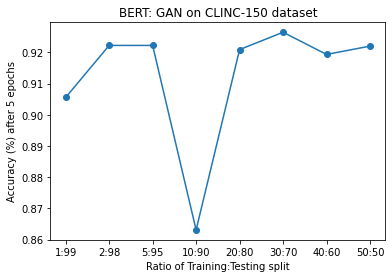

In [100]:
import matplotlib.pyplot as plt

y = [training_stats_1[-1]["Valid. Accur."], training_stats_2[-1]["Valid. Accur."], \
     training_stats_5[-1]["Valid. Accur."], training_stats[-1]["Valid. Accur."], training_stats_20[-1]["Valid. Accur."], \
     training_stats_30[-1]["Valid. Accur."], training_stats_40[-1]["Valid. Accur."]\
     , training_stats_50[-1]["Valid. Accur."]]
x = ["1:99","2:98","5:95", "10:90", "20:80", "30:70", "40:60", "50:50"]
plt.plot(x, y, '-o')

#plt.plot(x, y, label = "line 1")
#plt.plot(y, x, label = "line 2")
#plt.plot(x, np.sin(x), label = "curve 1")
#plt.plot(x, np.cos(x), label = "curve 2")

# naming the x axis
plt.xlabel('Ratio of Training:Testing split')
# naming the y axis
plt.ylabel('Accuracy (%) after 5 epochs')
# giving a title to my graph
plt.title('BERT: GAN on CLINC-150 dataset')
  
# function to show the plot
plt.show()

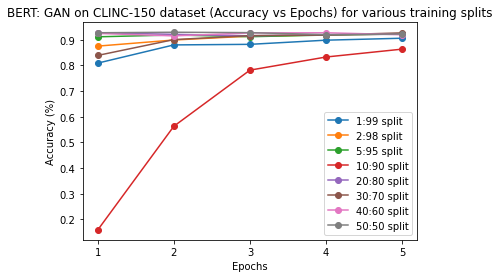

In [101]:
import matplotlib.pyplot as plt

y_1 = [training_stats_1[x]["Valid. Accur."] for x in range(num_train_epochs)]
y_2 = [training_stats_2[x]["Valid. Accur."] for x in range(num_train_epochs)]
y_5 = [training_stats_5[x]["Valid. Accur."] for x in range(num_train_epochs)]
y_10 = [training_stats[x]["Valid. Accur."] for x in range(num_train_epochs)]
y_20 = [training_stats_20[x]["Valid. Accur."] for x in range(num_train_epochs)]
y_30 = [training_stats_30[x]["Valid. Accur."] for x in range(num_train_epochs)]
y_40 = [training_stats_40[x]["Valid. Accur."] for x in range(num_train_epochs)]
y_50 = [training_stats_50[x]["Valid. Accur."] for x in range(num_train_epochs)]
x = ["1","2","3", "4", "5"]

plt.plot(x, y_1, '-o', label = "1:99 split")
plt.plot(x, y_2, '-o', label = "2:98 split")
plt.plot(x, y_5, '-o', label = "5:95 split")
plt.plot(x, y_10, '-o', label = "10:90 split")
plt.plot(x, y_20, '-o', label = "20:80 split")
plt.plot(x, y_30, '-o', label = "30:70 split")
plt.plot(x, y_40, '-o', label = "40:60 split")
plt.plot(x, y_50, '-o', label = "50:50 split")


# naming the x axis
plt.xlabel('Epochs')
# naming the y axis
plt.ylabel('Accuracy (%)')
# giving a title to my graph
plt.title('BERT: GAN on CLINC-150 dataset (Accuracy vs Epochs) for various training splits')
plt.legend()
  
# function to show the plot
plt.show()

In [102]:
print("Accuracies for different splits over 5 epochs:")
print("1:99", y_1)
print("2:98", y_2)
print("5:95", y_5)
print("10:90", y_10)
print("20:80", y_20)
print("30:70", y_30)
print("40:60", y_40)
print("50:50", y_50)

Accuracies for different splits over 5 epochs:
1:99 [0.8086666666666666, 0.8795555555555555, 0.8817777777777778, 0.898, 0.9055555555555556]
2:98 [0.8748888888888889, 0.8986666666666666, 0.9137777777777778, 0.9184444444444444, 0.9222222222222223]
5:95 [0.9111111111111111, 0.9182222222222223, 0.9115555555555556, 0.918, 0.9222222222222223]
10:90 [0.15911111111111112, 0.5628888888888889, 0.7813333333333333, 0.8324444444444444, 0.8631111111111112]
20:80 [0.9273333333333333, 0.9206666666666666, 0.9151111111111111, 0.9195555555555556, 0.9208888888888889]
30:70 [0.8386666666666667, 0.9002222222222223, 0.9157777777777778, 0.918, 0.9264444444444444]
40:60 [0.9242222222222222, 0.9146666666666666, 0.9262222222222222, 0.9268888888888889, 0.9193333333333333]
50:50 [0.9268888888888889, 0.9288888888888889, 0.9273333333333333, 0.9195555555555556, 0.922]
